# Inflation Forecast
---

The aim of this code is to fit an ARMA(p,q) model

$$y_{t} = c + \phi_{1}y_{t-1} + \dots + \phi_{p}y_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1}+\dots+\theta_{q}\epsilon_{t}$$
$$\epsilon_{t} \sim i.i.d.(0,\sigma^{2})$$

with inflation series and make a forecast based in that model.

## Libraries and data

In this first part the libraries and data are imported, with a preliminary graphical analysis of the series.

Text(0.5, 1.0, 'Peruvian Inflation, Monthly CPI percent change from year ago ')

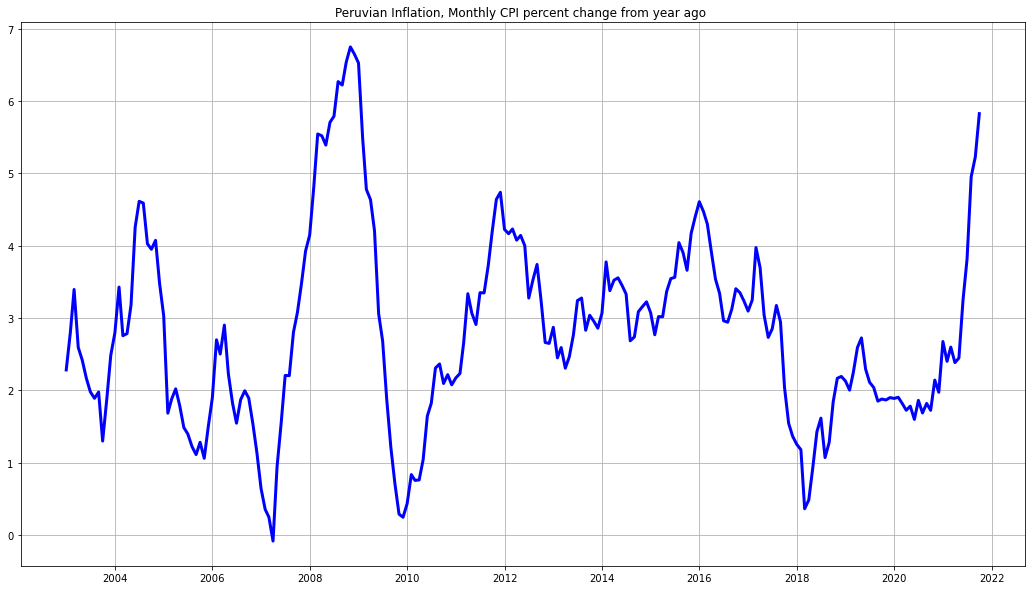

In [1]:
# Libraries
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt


from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import arma_order_select_ic

warnings.filterwarnings("ignore")

# Data
df = pd.read_csv(r".\data\inflation.csv")
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index).date

# A Plot of the series
fig, axs = plt.subplots(figsize=(18, 10))
axs.plot(df["inflation"],color='b',linewidth=3.0)
axs.grid(which='major')
axs.set_title("Peruvian Inflation, Monthly CPI percent change from year ago ")

## Auxiliar varibles and model selection

In this part are defined some auxiliar variables, can be changed by the user, that are necessary to get the ARMA(p,q) model fit and the forecast.

In [2]:
armax       = 4                                 # max AR order to test
mamax       = 2                                 # mas MA order to test
crit        = "aic"                             # selection criteria
ini_date    = df.index[0]                       # initial date
end_date    = df.index[-1]                      # final date
num_hor     = 3                                 # forecast periods
ini_forc    = (df.index[-1]
              + relativedelta(months=+1))       # initial forecast date
end_forc    = (df.index[-1]
              + relativedelta(months=+num_hor)) # final forecast date

With the auxiliar variables settled, it is time to perform the model selection.

In [3]:
lagresults = pd.DataFrame(columns=df.columns,index=range(0,1))

for c in df.columns:
    order_selec = arma_order_select_ic(df[c],
                                     max_ar = armax,
                                     max_ma = mamax,
                                     ic = crit)
    lagresults[c][0] = str(order_selec.aic_min_order) # Manual change for lag order criteria

lagresults

,inflation
0,"(3, 2)"


## Model estimation

Once the ARMA(p,q) order is identified, use the $p$ and $q$ order to estimate the model to forecast the data. With the forecast is common to construct confidence interval too.

In [4]:
# Model estimation
forcast_mod = sm.tsa.SARIMAX(df["inflation"],
                             order=(3, 0, 2), #(p,d,q)
                             trend='c') 
# Getting forecast
results_mod = forcast_mod.fit()
forecast_var = results_mod.get_forecast(steps=num_hor)


## Constructing Confidence Inteval (CI)

# Last obs of actual data
last_obs = df["inflation"][-1]
line = pd.to_datetime(end_date)
new_row = pd.DataFrame(last_obs,
                       columns=[0],
                       index=[line])

# Last obs with forecast
forecast_mean = forecast_var.predicted_mean
var_f_mean = pd.concat([pd.DataFrame(new_row),
                        forecast_mean])

# initial points of CI
new_row = pd.DataFrame([[last_obs,last_obs]],
                       columns=['lower inflation', 'upper inflation'],
                       index=[line])

# 95% CI
ci95 = forecast_var.conf_int()
pred_ci95 = pd.concat([pd.DataFrame(new_row),
                       ci95])

# 90% CI
ci90 = forecast_var.conf_int(alpha = .10) 
pred_ci90 = pd.concat([pd.DataFrame(new_row),
                         ci90])

# 68% CI
ci68 = forecast_var.conf_int(alpha = .36) 
pred_ci68 = pd.concat([pd.DataFrame(new_row),
                         ci68])

# 50% CI
ci50 = forecast_var.conf_int(alpha = .50) 
pred_ci50 = pd.concat([pd.DataFrame(new_row),
                       ci50])



## Forecast results
Finally let’s report the forecast results in a graphical manner

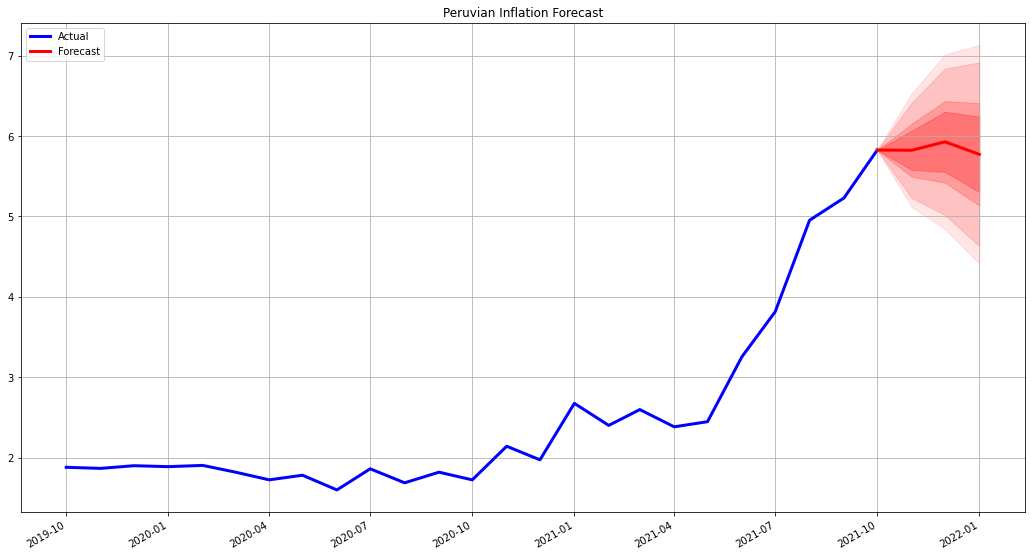

In [5]:
# Forecast graph
end_graf = (df.index[-1]
        - relativedelta(months=+24))

ax = df[end_graf:end_date]["inflation"].plot(figsize=(18, 10),
                                             color='b',
                                             linewidth=3.0)
var_f_mean.plot(ax=ax,
                color='r',
                linewidth=3.0)
ax.fill_between(pred_ci95.index,
                pred_ci95.iloc[:, 0],
                pred_ci95.iloc[:, 1],
                color='r',
                alpha=.10)
ax.fill_between(pred_ci90.index,
                pred_ci90.iloc[:, 0],
                pred_ci90.iloc[:, 1],
                color='r',
                alpha=.15)
ax.fill_between(pred_ci68.index,
                pred_ci68.iloc[:, 0],
                pred_ci68.iloc[:, 1],
                color='r',
                alpha=.20)
ax.fill_between(pred_ci50.index,
                pred_ci50.iloc[:, 0],
                pred_ci50.iloc[:, 1],
                color='r',
                alpha=.25)

plt.legend(['Actual', 'Forecast'],loc='upper left')
plt.title('Peruvian Inflation Forecast')
plt.grid("major")
plt.show()

A table format results is useful to have it too.

In [6]:
# results
print('--------------------------------------------------------------------------------------')
print('\t\t\t\t\t Table of Results\t')
print('--------------------------------------------------------------------------------------')
print('Date',
      '\t\t','Q2.5','\t', 'Q5','\t', 'Q16','\t', 'Q25','\t',
      'Mean',
      '\t', 'Q75','\t', 'Q84','\t', 'Q95','\t', 'Q97.5')
print('--------------------------------------------------------------------------------------')
for i in range(len(var_f_mean)):
    print(str(var_f_mean.index[i].date()),
          '\t',
          round(pred_ci95.iloc[i, 0],2),
          '\t',
          round(pred_ci90.iloc[i, 0],2),
          ' \t',
          round(pred_ci68.iloc[i, 0],2),
          ' \t',
          round(pred_ci50.iloc[i, 0],2),
          ' \t',
          round(float(var_f_mean.iloc[i]),2),
          '\t',
          round(pred_ci50.iloc[i, 1],2),
          '\t',
          round(pred_ci68.iloc[i, 1],2),
          '\t',
          round(pred_ci90.iloc[i, 1],2),
         '\t',
          round(pred_ci95.iloc[i, 1],2))
print('--------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------
					 Table of Results	
--------------------------------------------------------------------------------------
Date 		 Q2.5 	 Q5 	 Q16 	 Q25 	 Mean 	 Q75 	 Q84 	 Q95 	 Q97.5
--------------------------------------------------------------------------------------
2021-10-01 	 5.83 	 5.83  	 5.83  	 5.83  	 5.83 	 5.83 	 5.83 	 5.83 	 5.83
2021-11-01 	 5.12 	 5.23  	 5.49  	 5.58  	 5.82 	 6.07 	 6.15 	 6.42 	 6.53
2021-12-01 	 4.84 	 5.02  	 5.42  	 5.55  	 5.93 	 6.3 	 6.43 	 6.84 	 7.01
2022-01-01 	 4.41 	 4.63  	 5.14  	 5.3  	 5.77 	 6.24 	 6.41 	 6.91 	 7.13
--------------------------------------------------------------------------------------
